In [1]:
using ITensors,ITensorMPS
using LinearAlgebra
using Plots, LaTeXStrings

## SSH Model

In [51]:
include("sshmodel.jl")

SSH_ED (generic function with 2 methods)

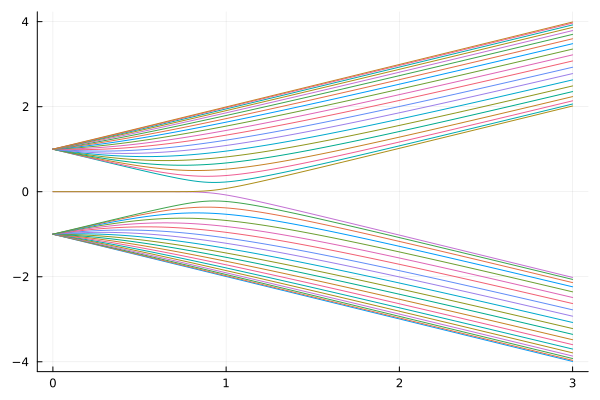

In [61]:
let 
    L=40
    w=1.0
    vs=range(0,3,101)
    spectrum=SSH_spectrum.(L,vs,w)
    spectrum=transpose(hcat(spectrum...))
    spec=SSH_spec.(L,vs,w)
    spec=transpose(hcat(spec...))
    plot(vs,spectrum,leg=false,w=1)
end

- plot data

In [3]:
energys_SSH, errs_SSH =let 
    L,D=40,6
    w=1.0
    vs=range(0.0,3.0,21)
    b_ent=Int(L/2)
    #DMRG parameters
    sw=Sweeps(15)
    setmaxdim!(sw,100)
    setcutoff!(sw,1E-14)
    krydim=4
    obs=EntangleObserver(b_ent)
    # ITE parameters
    cutoff=1.0E-12
    finaltemp=0.1
    tau=0.04
    steps=Int(ceil(1/finaltemp/tau))
    # initialize state
    state=[]
    for j in 1:L
        if isodd(j)
            push!(state,"1")
        else
            push!(state,"0")
        end
    end
    sites=siteinds("Fermion",L;conserve_qns=false)
    psi0=random_mps(sites;linkdims=D)

    energys=[]
    errs=[]
    for v in vs
        energy_ED=SSH_ED(L,v,w)
        Hssh=SSH_OBC(sites,v,w)
        sshgate=SSH_gate(sites,v,w,tau)
        energy_DMRG,psi_DMRG=dmrg(Hssh,psi0,sw;eigsolve_krylovdim=krydim,outputlevel=0)
        energy_ITE,psi_ITE=ImaginaryTimeEvolve(Hssh,sshgate,psi0,steps;cutoff=cutoff,display=false)
        err=[energy_DMRG-energy_ED energy_ITE-energy_ED]
        push!(energys,[energy_DMRG energy_ITE energy_ED])
        push!(errs,err)
    end
    energys=vcat(energys...)
    errs=vcat(errs...)
    energys, errs
end

([-18.99999999999999 -18.999999817677402 -19.0; -19.123941011691027 -19.123940692858234 -19.123941011691315; … ; -58.67846649476072 -58.67846609264609 -58.67846649476256; -61.59342193340838 -61.593421455277806 -61.593421933409985], [1.0658141036401503e-14 1.8232259790806893e-7; 2.877698079828406e-13 3.1883308082569783e-7; … ; 1.8403056856186595e-12 4.0211646989973815e-7; 1.6058265828178264e-12 4.781321791824666e-7])

- Plots

In [23]:
vs=range(0.0,3.0,21)
l=@layout([a{0.6h};b])
#plot(vs,energys_SSH,line=[:solid :solid :dash],label=["DMRG" "ITE" "ED"],framestyle=:box,xlabel=L"v",w=2,ylabel="energy")
#plot(vs,errs_SSH,label=["DMRG err" "ITE err"])
plot(plot(vs,energys_SSH,line=[:solid :solid :dash],label=["DMRG" "ITE" "ED"],w=2,ylabel="energy"),
    plot(vs,errs_SSH,line=:dashdot,label=["DMRG err" "ITE err"],xlabel="v",ylabel="err",yscale=:log10,w=1.5), layout=l,framestyle=:box,size=(600,450))
vline!([1.0],line=(1,:dash),label=false)
annotate!([(0.5,-55.0,(L"w=1"))])
savefig("figures/ssh_gndenergy.pdf")

"/home/zephyr/Documents/quantum_computation/tensornetwork/figures/ssh_gndenergy.pdf"

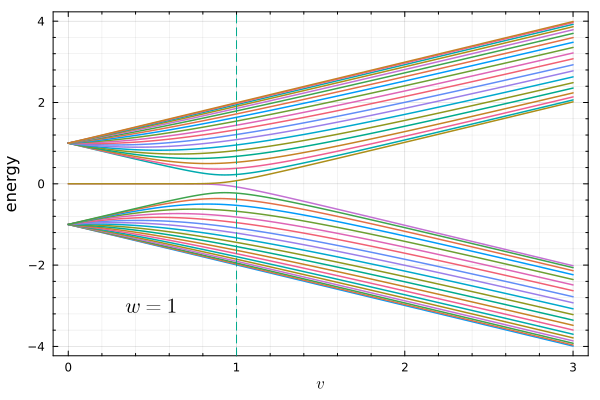

In [6]:
vx=range(0.0,3.0,101)
spectrum,states=
data=transpose(hcat(SSH_spectrum.(40,vx,1.0)...))
plot(vx,data,w=1.5,leg=false,xlabel=L"v",framestyle=:box)
yaxis!("energy",minorgrid=true)
vline!([1.0],line=(1,:dash))
annotate!([(0.5,-3,(L"w=1"))])
#savefig("figures/spectrum.pdf")

In [16]:
wavefuncs=let 
    v,w=0.5,1.0
    L=40
    _,states=SSH_spectrum(L,v,w;retstate=true)
    states
end

40×40 Matrix{Float64}:
 -0.0114066  -0.0227246  -0.0338646  …  0.0338646  -0.0227246  0.0114066
  0.034129    0.0674522   0.0991826     0.0991826  -0.0674522  0.034129
 -0.0453545  -0.0887453  -0.12831       0.12831    -0.0887453  0.0453545
  0.0674449   0.128514    0.17743       0.17743    -0.128514   0.0674449
 -0.0782219  -0.146358   -0.195672      0.195672   -0.146358   0.0782219
  0.0991539   0.1774      0.218225   …  0.218225   -0.1774     0.0991539
 -0.109226   -0.190105   -0.221731      0.221731   -0.190105   0.109226
  0.128501    0.20948     0.212957      0.212957   -0.20948    0.128501
 -0.137627   -0.215842   -0.200987      0.200987   -0.215842   0.137627
  0.154786    0.221713    0.162738      0.162738   -0.221713   0.154786
 -0.16275    -0.221129   -0.137819   …  0.137819   -0.221129   0.16275
  0.177383    0.212941    0.0781676     0.0781676  -0.212941   0.177383
 -0.183995   -0.205467   -0.0455591     0.0455591  -0.205467   0.183995
  ⋮                                  

In [25]:
let   
    n1,n2,n3=8,20,32
    l=@layout([a; b; c])
    plot(bar(wavefuncs[:,n1],color=repeat(1:2,20),framestyle=:box,label=latexstring("n=$(n1)")),
    bar(wavefuncs[:,n2],color=repeat(3:4,20),framestyle=:box,label=latexstring("n=$(n2)")),
    bar(wavefuncs[:,n3],color=repeat(5:6,20),framestyle=:box,label=latexstring("n=$(n3)")),
    layout=l,size=(600,600),ylim=(-0.25,0.25),xlabel="site" )
    savefig("figures/wavefunctions.pdf")
end

"/home/zephyr/Documents/quantum_computation/tensornetwork/figures/wavefunctions.pdf"

In [33]:
plot(vs,entropys_SSH,line=[:solid :solid],label=["DMRG" "ITE"],framestyle=:box,xlabel=L"v",w=2)
yaxis!("entropy",minorgrid=true)
vline!([1.0],line=(1,:dash),label=false)
annotate!([(0.5,0.25,(L"w=1"))])
#savefig("figures/ssh_gndentropy.pdf")

"/home/zephyr/Documents/quantum_computation/tensornetwork/figures/ssh_gndentropy.pdf"

- density on site

In [42]:
density_SSH_trivial,density_SSH_topology,density_SSH_transit=let 
    L,D=40,6
    v1,w1=2.0,1.0
    v2,w2=0.5,1.0
    v3,w3=1.0,1.0
    sw=Sweeps(15)
    setmaxdim!(sw,200)
    setcutoff!(sw,1E-14)
    krydim=4
    state=[]
    for j in 1:L
        if isodd(j)
            push!(state,"1")
        else
            push!(state,"0")
        end
    end
    sites=siteinds("Fermion",L;conserve_qns=false)
    psi0=random_mps(sites;linkdims=D)
    Htrivial=SSH_OBC(sites,v1,w1)
    Htopology=SSH_OBC(sites,v2,w2)
    Htransit=SSH_OBC(sites,v3,w3)
    energy1,psi1=dmrg(Htrivial,psi0,sw;eigsolve_krylovdim=krydim,outputlevel=0)
    energy2,psi2=dmrg(Htopology,psi0,sw;eigsolve_krylovdim=krydim,outputlevel=0)
    energy3,psi3=dmrg(Htransit,psi0,sw;eigsolve_krylovdim=krydim,outputlevel=0)
    density1=expect(psi1,"N")
    density2=expect(psi2,"N")
    density3=expect(psi3,"N")
    density1, density2,density3
end

([0.49999999999998196, 0.49999999999998934, 0.4999999999999958, 0.5000000000000113, 0.5000000000000003, 0.5000000000000062, 0.4999999999999939, 0.4999999999999906, 0.4999999999999982, 0.49999999999997385  …  0.4999999999999983, 0.4999999999999138, 0.5000000000000577, 0.499999999999938, 0.49999999999988676, 0.5000000000002164, 0.49999999999999667, 0.5000000000001791, 0.5000000000000105, 0.5000000000000336], [0.7729374357074779, 0.5000000644570033, 0.5682342365797991, 0.5000000571610778, 0.5170586438689702, 0.4999999985318212, 0.5042646132441664, 0.5000000004769599, 0.5010661742445949, 0.4999999904927083  …  0.5000000000682304, 0.4986520911092337, 0.49999999970211617, 0.4946083636174962, 0.5000000004119918, 0.47843345482247057, 0.5000000003359794, 0.41373382130391884, 0.5000000000714969, 0.15493528595466396], [0.5000000000000022, 0.49999999999997913, 0.5000000000000079, 0.49999999999999756, 0.5000000000000158, 0.5000000000000125, 0.5000000000000154, 0.5000000000000148, 0.5000000000000049

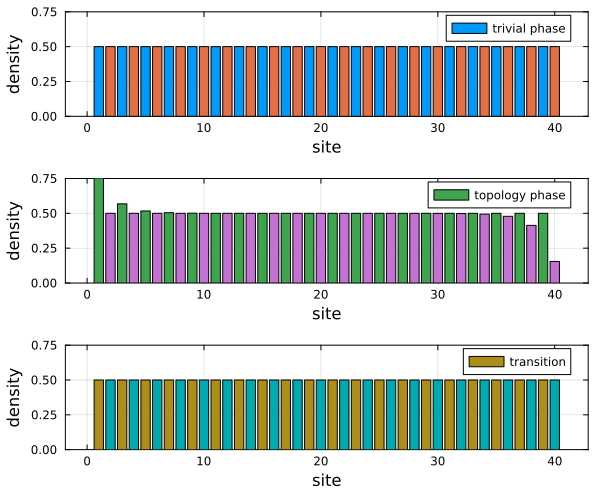

In [45]:
l=@layout([a; b; c])
plot(bar(density_SSH_trivial,color=repeat(1:2,20),framestyle=:box,label="trivial phase"),
bar(density_SSH_topology,framestyle=:box,color=repeat(3:4,20),label="topology phase"),
bar(density_SSH_transit,framestyle=:box,color=repeat(5:6,20),label="transition"),
layout=l,xlabel="site",ylabel="density",ylim=(0,0.75),size=(600,500))
#savefig("figures/density_SSH.pdf")